<a href="https://colab.research.google.com/github/gaixen/Pytorch_Projects/blob/main/Pytorch_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Dependencies


In [ ]:
pip install jupyterthemes --quiet

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print(device)

cuda


In [ ]:
import seaborn as sns
import jupyterthemes as jt
from jupyterthemes import get_themes

## Data-Trends

In [ ]:
df = pd.read_csv('/content/riceClassification.csv')
print(df.shape)
print(df.columns)
df.head()

(18185, 12)
Index(['id', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness',
       'AspectRation', 'Class'],
      dtype='object')


,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
df.dropna(inplace =True)
print(df.shape[0])

18185


In [ ]:
df = df[[col for col in df.columns if col not in ['id']]]

In [ ]:
df.columns

Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness',
       'AspectRation', 'Class'],
      dtype='object')

In [ ]:
for col in ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness',
       'AspectRation']:
  df[col] = df[col]/df[col].abs().max()

df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1


In [ ]:
df['Class'].value_counts()

,count
Class,
1,9985
0,8200


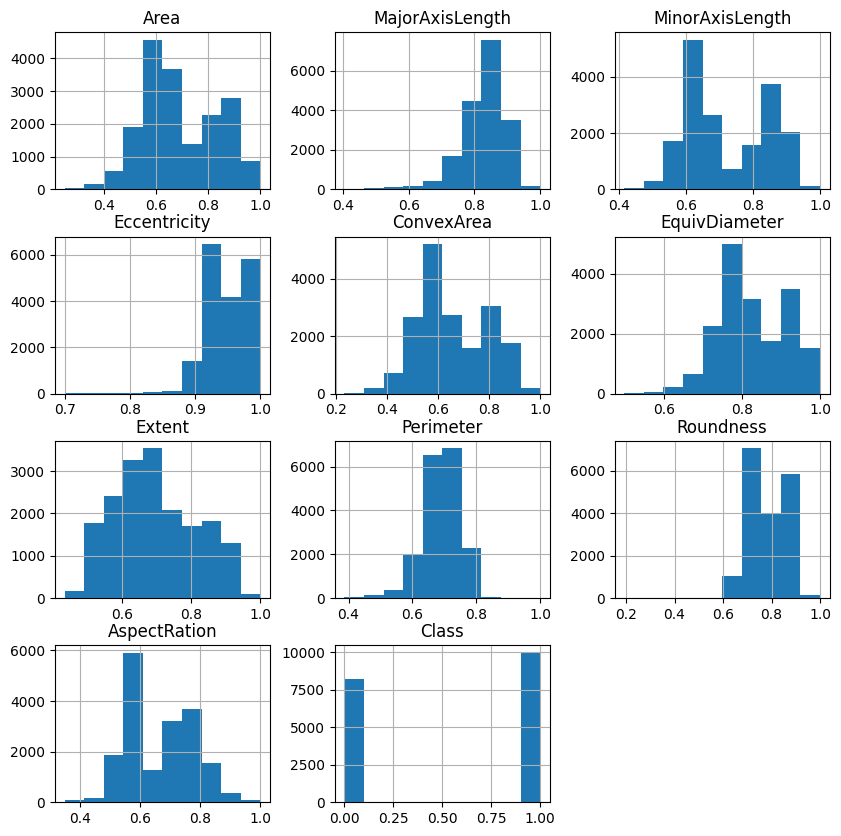

In [ ]:
df.hist(figsize=(10,10))
plt.show()

<Axes: >

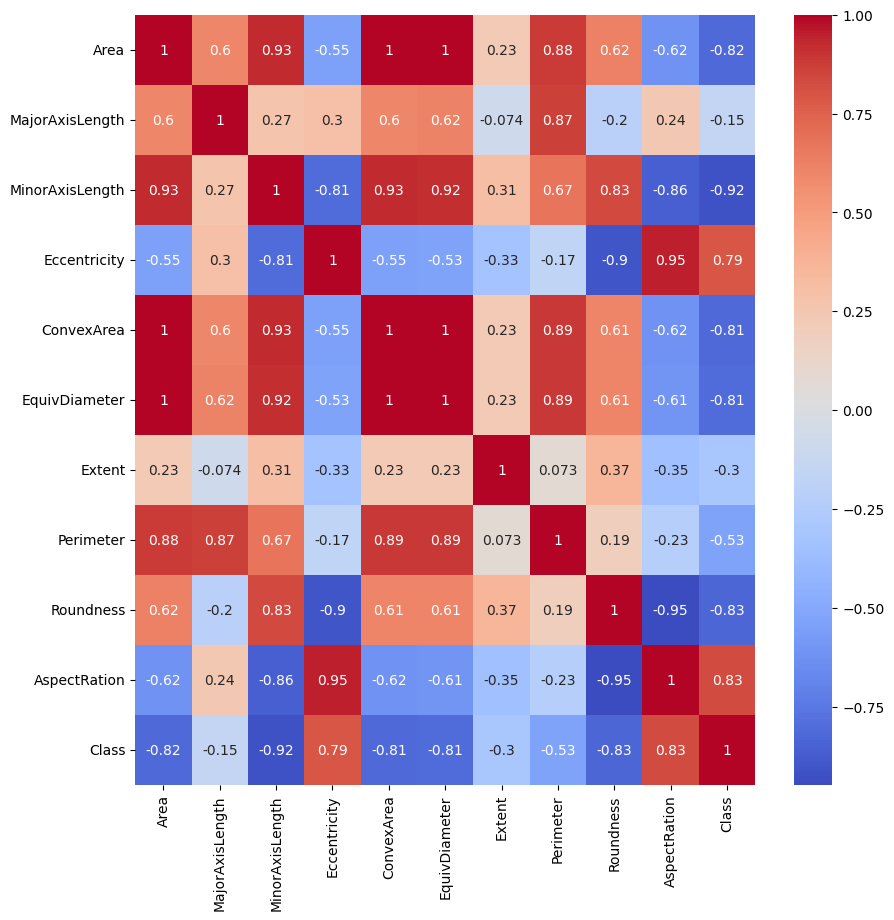

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

In [ ]:
brightness_order = '1','0'

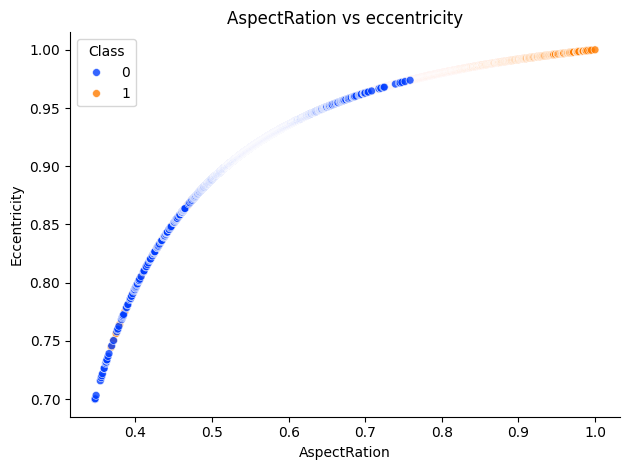

In [ ]:
sns.scatterplot(data=df,x='AspectRation',y='Eccentricity',hue='Class',
              palette='bright',s=32,alpha=0.8)

plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('AspectRation')
plt.ylabel('Eccentricity')
plt.title('AspectRation vs eccentricity')
plt.tight_layout()
plt.show()

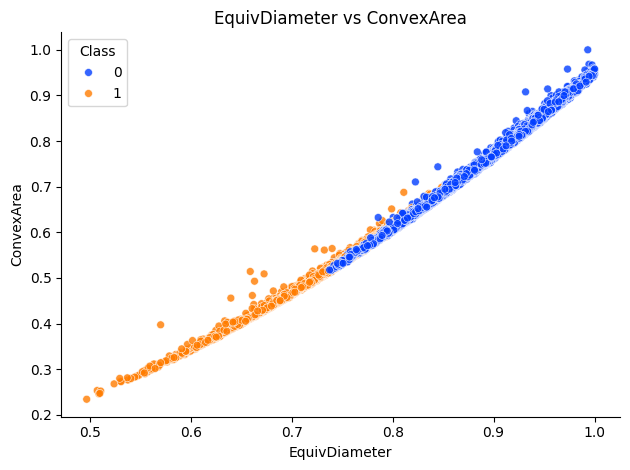

In [ ]:
sns.scatterplot(data=df,x='EquivDiameter',y='ConvexArea',hue='Class',
              palette='bright',s=32,alpha=0.8)

plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('EquivDiameter')
plt.ylabel('ConvexArea')
plt.title('EquivDiameter vs ConvexArea')
plt.tight_layout()
plt.show()

## Training the model

In [ ]:
x = np.array(df.iloc[:,:-1])
y= np.array(df.iloc[:,-1])
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)
x_test , x_val,y_test,y_val = train_test_split(x_test,y_test,test_size=0.5,random_state=42)
print(x_train.shape[0],"\n",x_test.shape[0],"\n",x_val.shape[0])

12729 
 2728 
 2728


In [ ]:
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype =torch.float32).to(device)
    self.y = torch.tensor(y,dtype =torch.float32).to(device)
  def __len__(self):
    return len(self.x)
  def __getitem__(self , index):
    return self.x[index] , self.y[index]

training_dataset = dataset(x_train,y_train)
testing_dataset = dataset(x_test,y_test)
validation_dataset = dataset(x_val,y_val)

In [ ]:
epochs = 10
batch_size = 32
hidden_neurons = 10
lr = 0.01

In [ ]:
train_dataloader = DataLoader(training_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader (testing_dataset ,batch_size=batch_size ,shuffle=True)
validation_dataloader=DataLoader(validation_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
class model(nn.Module):
  def __init__(self):
    super(model,self).__init__()
    self.input_layer = nn.Linear(x.shape[1],hidden_neurons)
    self.Linear = nn.Linear(hidden_neurons,1)
    self.Sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.input_layer(x)
    x = self.Linear(x)
    x = self.Sigmoid(x)
    return x

In [ ]:
model = model().to(device)
summary(model,(x.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr=lr)

In [ ]:
total_loss_train_plot=[]
total_loss_validation_plot=[]
total_accuracy_train_plot=[]
total_accuracy_validation_plot=[]

for epoch in range(epochs):
  total_accuracy_train=0
  total_accuracy_validation=0
  total_loss_train=0
  total_loss_validation=0

  for data in train_dataloader:
    inputs , labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction,labels)
    total_loss_train += batch_loss.item()
    accuracy = ((prediction).round()==labels).sum().item()
    total_accuracy_train +=accuracy
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in validation_dataloader:
       inputs , labels = data
       prediction = model(inputs).squeeze(1)
       batch_loss = criterion(prediction,labels)
       total_loss_validation += batch_loss.item()
       accuracy = ((prediction).round()==labels).sum().item()
       total_accuracy_validation +=accuracy

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_validation/1000,4))
  total_accuracy_train_plot.append(round(total_accuracy_train/(training_dataset.__len__())*100,4))
  total_accuracy_validation_plot.append(round(total_accuracy_validation/(validation_dataset.__len__())*100,4))

  print(f"epoch no.{epoch +1} Train Loss:{total_loss_train/1000},total loss validation:{total_loss_validation/1000},accuracy train:{total_accuracy_train/(training_dataset.__len__())*100},accuracy validation:{total_accuracy_validation/(validation_dataset.__len__())*100}")
  print("="*70)

epoch no.1 Train Loss:0.07187204831978306,total loss validation:0.004057496687397361,accuracy train:94.7285725508681,accuracy validation:98.60703812316716
epoch no.2 Train Loss:0.019352718317648395,total loss validation:0.00398262738873018,accuracy train:98.36593605153587,accuracy validation:98.60703812316716
epoch no.3 Train Loss:0.019393025732366367,total loss validation:0.004455173767142696,accuracy train:98.42878466493833,accuracy validation:98.49706744868035
epoch no.4 Train Loss:0.019124217179836707,total loss validation:0.003960830642201472,accuracy train:98.25595097808154,accuracy validation:98.38709677419355
epoch no.5 Train Loss:0.018340540380915628,total loss validation:0.0040794329096097495,accuracy train:98.3973603582371,accuracy validation:98.31378299120234
epoch no.6 Train Loss:0.0185639730154071,total loss validation:0.004501639753754717,accuracy train:98.44449681828895,accuracy validation:98.46041055718476
epoch no.7 Train Loss:0.019210270554554883,total loss validatio